In [1]:
import cv2
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity
from skimage.util import img_as_ubyte, img_as_float
from skimage.color import *

# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def calibrate_camera():
    nx = 9
    ny = 6
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Get image shape
    img_shape = plt.imread('camera_cal/calibration1.jpg').shape[0:2]
    img_shape = {'x': img_shape[1], 'y': img_shape[0]}
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'camera_cal/corners_found/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
    
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img_shape['x'], img_shape['y']), None, None)
    return ret, mtx, dist, rvecs, tvecs

In [88]:
def convert_to_grayscale(img, in_type = ''):
    assert in_type in ['HSV', 'HLS', 'RGB', 'BGR']
    if in_type == 'HSV':
        img_gray = cv2.cvtColor(img, cv2.COLOR_HSV2GRAY)
    elif in_type == 'HLS':
        img_gray = cv2.cvtColor(img, cv2.COLOR_HLS2GRAY)
    elif in_type == 'RGB':
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif in_type == 'BGR':
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

def get_RGB_channels(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    return R,G,B

def get_HLS_channels(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = img[:,:,0]
    L = img[:,:,1]
    S = img[:,:,2]
    
    return H, L, S

def get_HSV_channels(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = img[:,:,0]
    S = img[:,:,1]
    V = img[:,:,2]
    
    return H, S, V

In [188]:
def sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    thresh_max = thresh[1]
    thresh_min = thresh[0]
    
    # Ensure img is grayscale
    assert orient in ['x','y']
    if len(img.shape) == 3:
        assert img.shape[2] == 1
    
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    
    elif orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sobel_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Calculate directional gradient
    thresh_max = thresh[1]
    thresh_min = thresh[0]
    
    if len(img.shape) == 3:
        assert img.shape[2] == 1
        
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    gradient_mag = np.sqrt(sobelx**2+sobely**2)
    scale_factor = np.max(gradient_mag)/255
    gradient_mag = (gradient_mag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(gradient_mag)
    mag_binary[(gradient_mag > thresh_min) & (gradient_mag < thresh_max)] = 1
    
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(-np.pi/2, np.pi/2)):
    # Calculate gradient direction
    thresh_max = thresh[1]
    thresh_min = thresh[0]
    
    if len(img.shape) == 3:
        assert img.shape[2] == 1
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 1,0, ksize = sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh_min) & (grad_dir <= thresh_max)] = 1
    dir_binary[dir_binary != dir_binary]
    
    return dir_binary

In [179]:
def get_binary(img, thresh = (0,255)):
    
    binary = np.zeros_like(img)
    
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    
    return binary

In [766]:
def set_mask(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    
    vertices = np.array([[(80,700), (350,400), (930,400), (1200,700)]])
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [754]:
def get_perspective_transform(BL, BR, UL, UR):
    #straight_lines = plt.imread('test_images/straight_lines2.jpg')
    #straight_lines = convert_to_grayscale(straight_lines, in_type = 'RGB')
    #straight_lines = cv2.undistort(straight_lines, mtx, dist, None, mtx)
    #straight_lines_drawn = cv2.undistort(plt.imread('test_images/straight_lines2.jpg'), mtx, dist, None, mtx)

    src = np.float32([BL, UL, BR, UR])
    dst = np.float32([[320, 720], [320, 0], [960,720], [960,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return M, M_inv

def get_perspective_transform_v2():
    
    img_size = (1280,720)
    
    b_width = 0.76 
    m_width = 0.08
    h_pct = 0.62
    trim_pct = 0.935
    offset = img_size[0]*0.20
    # BL, BR, UL, UR
    src = np.float32([[img_size[0]*(0.5-b_width/2), img_size[1]*trim_pct], [img_size[0]*(0.5+b_width/2), img_size[1]*trim_pct], [img_size[0]*(0.5-m_width/2), img_size[1]*h_pct], [img_size[0]*(0.5+m_width/2), img_size[1]*h_pct]])
    dst = np.float32([[offset, img_size[1]], [img_size[0]-offset,img_size[1]], [offset, 0], [img_size[0]-offset, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return M, M_inv

def perspective_transform(img, M):
    img_transformed = cv2.warpPerspective(img, M, dsize = (1280, 720))
    if len(img_transformed.shape) > 2:
        if img_transformed.shape[2]==4:
            img_transformed = img_as_ubyte(img_transformed)[:,:,:-1]
    
    return img_transformed

In [182]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()

In [8]:
persp1 = plt.imread('test_images/straight_lines1_undistorted.png')
persp2 = plt.imread('test_images/straight_lines2_undistorted.png')

In [606]:
color = (255,0,0)
thickness = 3
BL = [246, 690]
BR = [1058, 690]
UL = [560, 475]
UR = [726, 475]

#M, M_inv = get_perspective_transform(BL, BR, UL, UR)
M, M_inv = get_perspective_transform_v2()
persp1_warped = perspective_transform(persp1, M)
persp2_warped = perspective_transform(persp2, M)

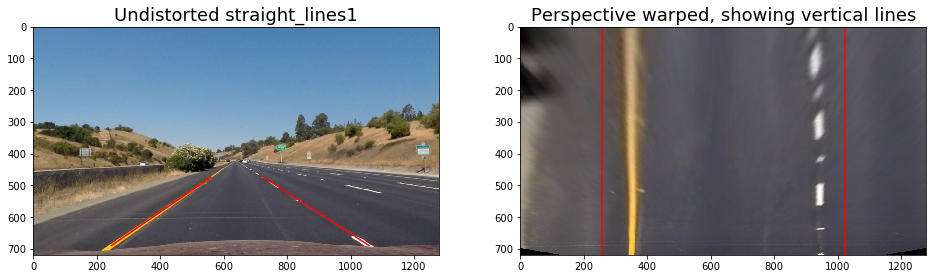

In [607]:
f, (ax1, ax2) = plt.subplots(1,2,figsize = (16,9))
offset = persp1.shape[1]*0.20
ax1.imshow(persp1)
ax1.set_title('Undistorted straight_lines1', fontsize = 18)
ax1.plot([BL[0], UL[0]], [BL[1], UL[1]], color = 'red')
ax1.plot([BR[0], UR[0]], [BR[1], UR[1]], color = 'red')
ax2.imshow(persp1_warped)
ax2.axvline(x=offset, color = 'red')
ax2.axvline(x=persp2_warped.shape[1]-offset, color = 'red')
ax2.set_title('Perspective warped, showing vertical lines', fontsize = 18)
plt.savefig('report_images/perspective_testing1.png')

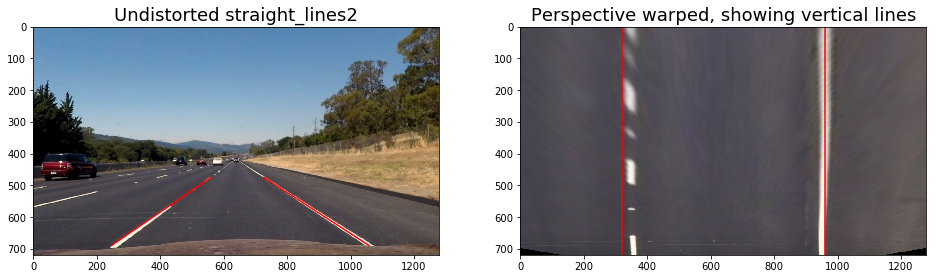

In [608]:
f, (ax1, ax2) = plt.subplots(1,2,figsize = (16,9))
ax1.imshow(persp2)
ax1.set_title('Undistorted straight_lines2', fontsize = 18)
ax1.plot([BL[0], UL[0]], [BL[1], UL[1]], color = 'red')
ax1.plot([BR[0], UR[0]], [BR[1], UR[1]], color = 'red')
ax2.imshow(persp2_warped)
ax2.axvline(x=320, color = 'red')
ax2.axvline(x=960, color = 'red')
ax2.set_title('Perspective warped, showing vertical lines', fontsize = 18)
plt.savefig('report_images/perspective_testing2.png')

### Test Image Descriptions

test1  - concrete, yellow-solid/white-dashed

test4 - tarmac & concrete, yellow-solid/white-dashed

test5 - concrete & tarmac w/shadow, yellow-solid/white-dashed

test18 - concrete & car in next lane, yellow-solid/white-dashed


In [987]:
img_name = 'test18'

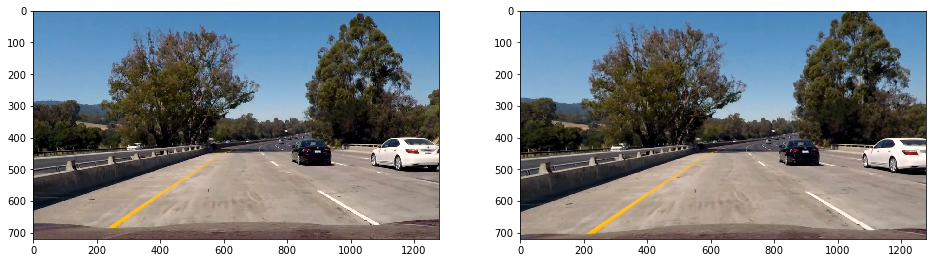

In [988]:
test_image = plt.imread('test_images/{}.jpg'.format(img_name))
#test_image = convert_to_grayscale(test_image, in_type = 'RGB')
undistorted_og = cv2.undistort(test_image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,9))
ax1.imshow(test_image, cmap = 'gray')
ax2.imshow(undistorted_og, cmap = 'gray')

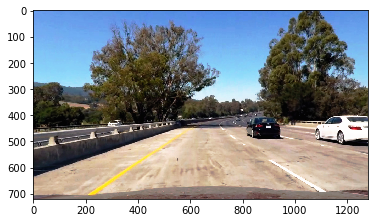

In [989]:
undistorted = img_as_ubyte(equalize_hist(undistorted_og))
plt.imshow(undistorted)

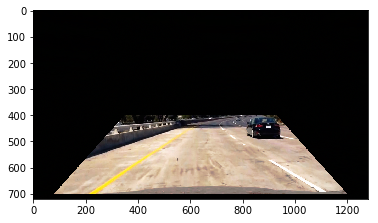

In [990]:
#masked_warped = img_as_ubyte(equalize_adapthist(rescale_intensity(perspective_transform(set_mask(undistorted), M))))
masked = set_mask(undistorted)
masked_warped = img_as_ubyte(equalize_adapthist(rescale_intensity(perspective_transform(masked, M))))
#masked_warped = perspective_transform(masked, M)
plt.imshow(masked)

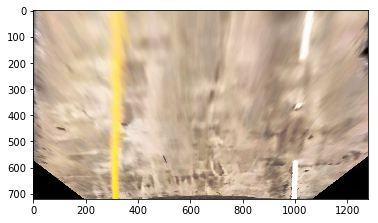

In [991]:
plt.imshow(masked_warped)

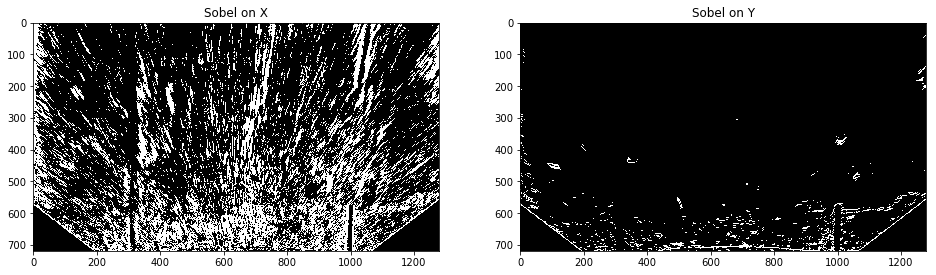

In [992]:
threshx = (5, 255)
threshy = (20, 255)
sobelx = sobel_thresh(convert_to_grayscale(masked_warped, in_type = 'RGB'), orient = 'x', thresh = threshx)
sobely = sobel_thresh(convert_to_grayscale(masked_warped, in_type = 'RGB'), orient = 'y', thresh = threshy)
f, (ax1, ax2) = plt.subplots(1,2,figsize = (16,9))
ax1.imshow(sobelx, cmap = 'gray')
ax1.set_title('Sobel on X')
ax2.imshow(sobely, cmap = 'gray')
ax2.set_title('Sobel on Y')

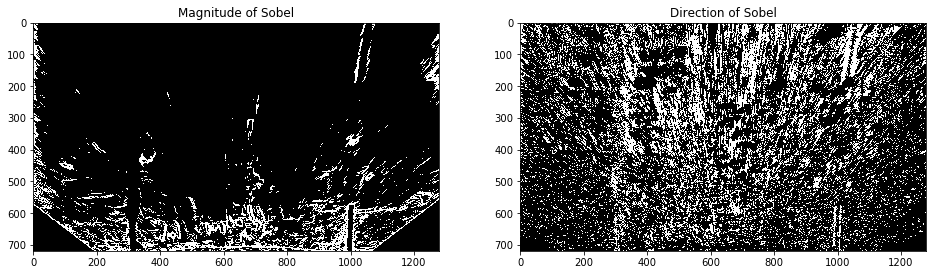

In [993]:
threshmag = (10, 255)
mag = mag_thresh(convert_to_grayscale(masked_warped, in_type = 'RGB'), thresh = threshmag)
threshdir = (np.pi/2-np.pi/8, np.pi/2+np.pi/8)
dirt = dir_thresh(convert_to_grayscale(masked_warped, in_type = 'RGB'), thresh = threshdir)

f, (ax1, ax2) = plt.subplots(1,2,figsize = (16,9))
ax1.imshow(mag, cmap = 'gray')
ax1.set_title('Magnitude of Sobel')
ax2.imshow(dirt, cmap = 'gray')
ax2.set_title('Direction of Sobel')

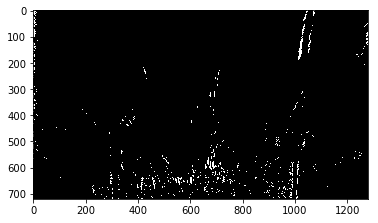

In [994]:
combined = np.zeros_like(mag)
#combined[(((sobelx == 1) & (mag == 1)) | ((dirt == 1) & (sobely == 1)))] = 1
combined[((sobelx == 1) & (dirt == 1)) & (mag == 1)] = 1
plt.imshow(combined, cmap = 'gray')

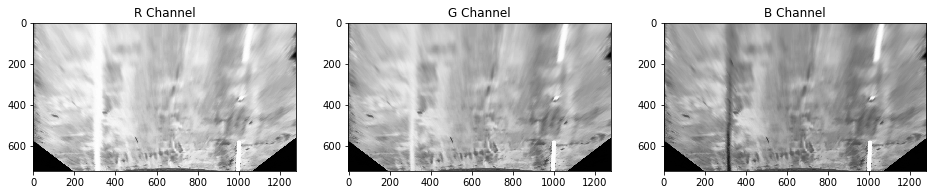

In [995]:
R,G,B = get_RGB_channels(masked_warped)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,9))
ax1.imshow(R, cmap = 'gray')
ax1.set_title('R Channel')
ax2.imshow(G, cmap = 'gray')
ax2.set_title('G Channel')
ax3.imshow(B, cmap = 'gray')
ax3.set_title('B Channel')

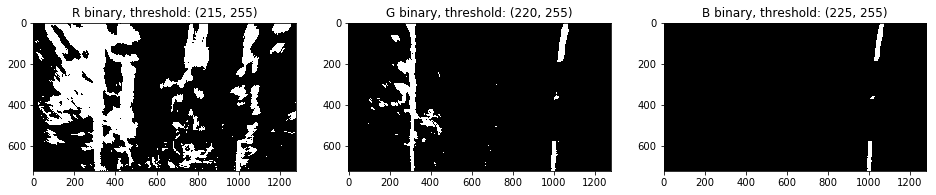

In [996]:
R_thresh = (215,255)
G_thresh = (220,255)
B_thresh = (225,255)
R_binary = get_binary(R, thresh = R_thresh)
G_binary = get_binary(G, thresh = G_thresh)
B_binary = get_binary(B, thresh = B_thresh)
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (16,9))
ax1.imshow(R_binary, cmap = 'gray')
ax1.set_title('R binary, threshold: {}'.format(R_thresh))
ax2.imshow(G_binary, cmap = 'gray')
ax2.set_title('G binary, threshold: {}'.format(G_thresh))
ax3.imshow(B_binary, cmap = 'gray')
ax3.set_title('B binary, threshold: {}'.format(B_thresh))

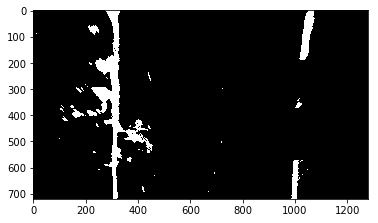

In [997]:
RGB_combined = np.zeros_like(R_binary)
#RGB_combined[(R_binary == 1) & ((G_binary == 1) != (B_binary ==1))] = 1
RGB_combined[(R_binary == 1) & (G_binary == 1) | (B_binary ==1)] = 1

plt.imshow(RGB_combined, cmap = 'gray')

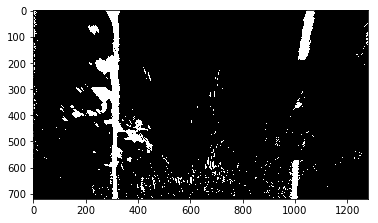

In [998]:
combined_2 = np.zeros_like(RGB_combined)
combined_2[(RGB_combined == 1) | (combined == 1)] = 1
plt.imshow(combined_2, cmap = 'gray')

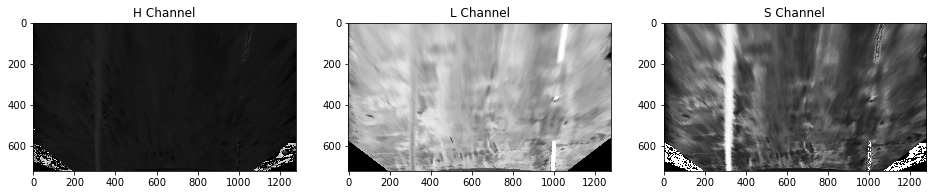

In [999]:
H,L,S = get_HLS_channels(masked_warped)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,9))
ax1.imshow(H, cmap = 'gray')
ax1.set_title('H Channel')
ax2.imshow(L, cmap = 'gray')
ax2.set_title('L Channel')
ax3.imshow(S, cmap = 'gray')
ax3.set_title('S Channel')

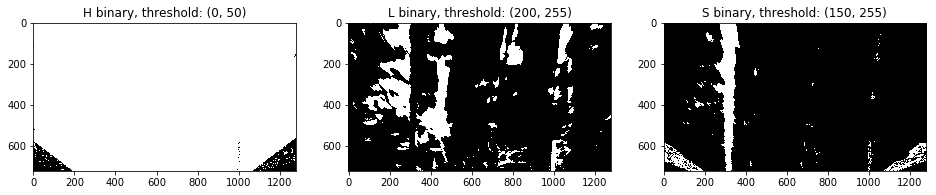

In [1000]:
H_thresh = (0,50)
L_thresh = (200,255)
S_thresh = (150,255)
H_binary = get_binary(H, thresh = H_thresh)
L_binary = get_binary(L, thresh = L_thresh)
S_binary = get_binary(S, thresh = S_thresh)
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (16,9))
ax1.imshow(H_binary, cmap = 'gray')
ax1.set_title('H binary, threshold: {}'.format(H_thresh))
ax2.imshow(L_binary, cmap = 'gray')
ax2.set_title('L binary, threshold: {}'.format(L_thresh))
ax3.imshow(S_binary, 'gray')
ax3.set_title('S binary, threshold: {}'.format(S_thresh))

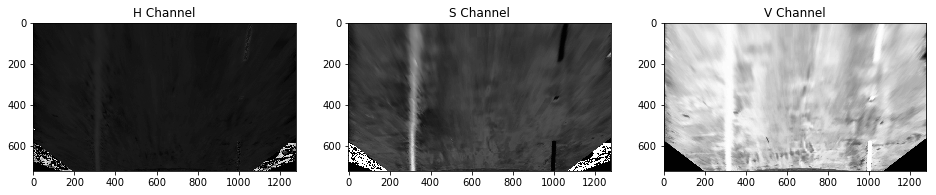

In [1001]:
H, S, V = get_HSV_channels(masked_warped)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,9))
ax1.imshow(H, cmap = 'gray')
ax1.set_title('H Channel')
ax2.imshow(S, cmap = 'gray')
ax2.set_title('S Channel')
ax3.imshow(V, cmap = 'gray')
ax3.set_title('V Channel')

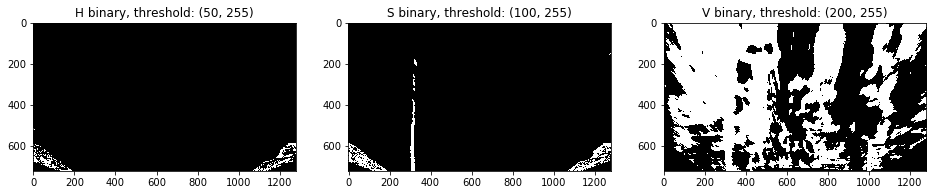

In [1002]:
H_thresh = (50,255)
S_thresh_2 = (100,255)
V_thresh = (200, 255)
H_binary = get_binary(H, thresh = H_thresh)
S_binary_2 = get_binary(S, thresh = S_thresh)
V_binary = get_binary(V, thresh = V_thresh)
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (16,9))
ax1.imshow(H_binary, cmap = 'gray')
ax1.set_title('H binary, threshold: {}'.format(H_thresh))
ax2.imshow(S_binary_2, cmap = 'gray')
ax2.set_title('S binary, threshold: {}'.format(S_thresh_2))
ax3.imshow(V_binary, 'gray')
ax3.set_title('V binary, threshold: {}'.format(V_thresh))

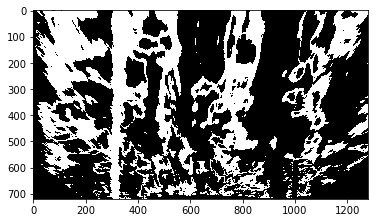

In [1003]:
arb_img = np.zeros_like(test_image)
arb_img[(V_binary != L_binary)] = 255
plt.imshow(arb_img, cmap = 'gray')

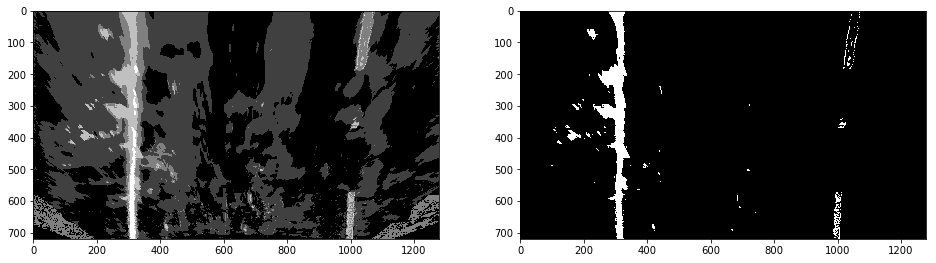

In [1004]:
avg_img = img_as_ubyte(np.average([S_binary, V_binary, RGB_combined, S_binary_2, combined], axis = 0))
avg_thresh = (125,255)
avg_binary = get_binary(avg_img, thresh = avg_thresh)
f, (ax1, ax2) = plt.subplots(1,2, figsize = (16,9))
ax1.imshow(avg_img, cmap = 'gray')
ax2.imshow(avg_binary, cmap = 'gray')

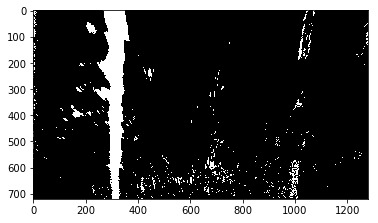

In [1005]:
final_binary = np.zeros_like(S_binary)
#final_binary[ (S_binary == 1) | (combined_2 ==1 ) ] = 1
#final_binary[((S_binary == 1) | (L_binary == 1)) & ((V_binary != H_binary))] = 1
final_binary[((S_binary == 1) & (V_binary == 1)) | (combined == 1)] = 1

plt.imshow(final_binary, cmap = 'gray')

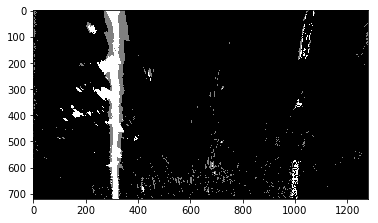

In [1006]:
final_avg = img_as_ubyte(np.average([final_binary, avg_binary], axis = 0))
plt.imshow(final_avg, cmap = 'gray')

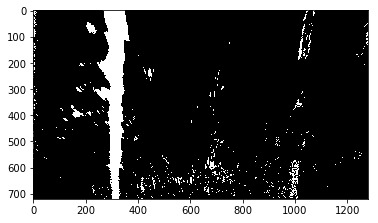

In [1007]:
final_binary = get_binary(final_avg, thresh = (100,255))
plt.imshow(final_binary, cmap = 'gray')

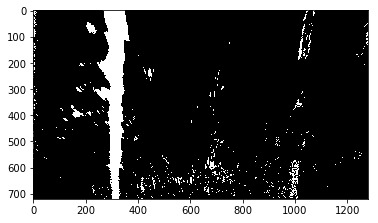

In [1008]:
color = (255,0,0)
thickness = 3
M, M_inv = get_perspective_transform(BL, BR, UL, UR)
#binary_warped = perspective_transform(final_binary*255, M)
#binary_warped = gray2rgb(binary_warped)
#cv2.line(binary_warped, (320,720), (320,0), color, thickness)
#cv2.line(binary_warped, (960,720), (960,0), color, thickness)
binary_warped = final_binary
plt.imshow(binary_warped, cmap = 'gray')


In [1015]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom quarter of the image
histogram = np.sum(binary_warped[3*binary_warped.shape[0]//4:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 80
# Set minimum number of pixels found to recenter window
minpix = 10
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,255), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,0,255), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 
#leftx_expanded = np.append(leftx, rightx-640)
#lefty_expanded  = np.append(lefty, righty)
#rightx_expanded = np.append(rightx, leftx+640)
#righty_expanded = np.append(righty, lefty)
leftx_expanded = leftx
lefty_expanded = lefty
rightx_expanded = rightx
righty_expanded = righty

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty_expanded, leftx_expanded, 2)
right_fit = np.polyfit(righty_expanded, rightx_expanded, 2)


(720, 0)

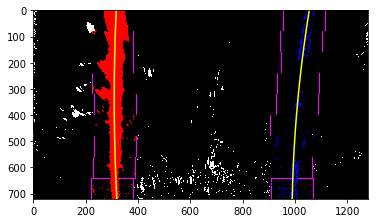

In [1016]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

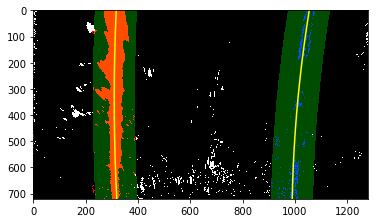

In [1017]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [1018]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

7536.01786181 5095.4211398


In [1019]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

2465.81997308 m 1672.64423007 m


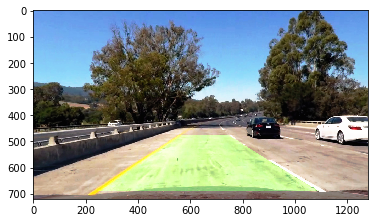

In [1020]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M_inv, (test_image.shape[1], test_image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
plt.imshow(result)